In [33]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from profanity import profanity
# from collections import Counter
import numpy as np
from scipy.stats import pearsonr

In [34]:
# Dictionary that holds counts for words and unique words in every song

lyrics = defaultdict(dict)

words_per_song = defaultdict(dict)
unique_words_per_song = defaultdict(dict)

# Dictionary that holds counts for words per album
words_per_album = defaultdict(int)
unique_words_per_album = defaultdict(int)

# Dictionary that keeps track of the average number of words in a song per album
average_words_per_album = defaultdict(float)

average_unique_words_per_album = defaultdict(float)

# Dictionary that holds the number of songs per album
num_songs = {}

# Dictionary that holds the most used words in an album
album_most_used_words = defaultdict(list[str])

# Dictionary that holds the most used words in entire discography (to be plotted over albums and see how use changes)
most_used_words = list

all_words_in_album = defaultdict(str)

average_word_length = {}

# Iterates over all of the directories
for root, dirs, files in os.walk('songs_excl_ftv', topdown=True):

    for dir in dirs:
        for file in os.listdir(os.path.join("songs_excl_ftv/", dir)):
            title = os.path.join(f"songs_excl_ftv/{dir}", file)
            words = []
            with open(title) as t:
                word_list = []
                for line in t.readlines():
                    word_list.append(line.rstrip())
                lyrics[dir][os.path.basename(title)] = word_list
        


In [35]:
pronouns = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 
                'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 
                'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']

In [36]:
# List that holds all of the words in every song
all_words = []

swear_dictionary = {}

pronoun_dictionary = defaultdict(dict)

average_word_length_across_albums = {}

for album, song in lyrics.items():

    swear_count = 0

    # List that holds all of the words in a given album
    album_words = []

    # Saves the number of songs per album
    song_num = len(song.values())
    num_songs[album] = song_num

    # Set that saves the unique words in an album
    unique_words = set()

    # list which will store the most frequently appearing words across an album
    album_most_freq = defaultdict(int)

    average_word_length_in_album = []

    for title, word_list in song.items():
        # Saves the number of words and unique words per song
        total_sum = len(word_list)
        unique_sum = len(set(word_list))
        words_per_song[album][title] = total_sum
        unique_words_per_song[album][title] = unique_sum
        

        profanity_bool = profanity.contains_profanity(" ".join(word_list))
        if profanity_bool:
            swear_count += 1

        char_count_list = []
        
        for word in word_list:
            char_count = 0
            if word not in album_words:
                for char in word:
                    char_count += 1
                char_count_list.append(char_count)
            
            album_words.append(word)
            all_words.append(word)

            # Updates the word count of a word in an album
            words_per_album[album] += 1
            unique_words.add(word)
            

            if word in pronouns:
                if word not in pronoun_dictionary[album].keys():
                    pronoun_dictionary[album][word] = 1
                else:
                    pronoun_dictionary[album][word] += 1
        
        unique_words_per_album[album] = len(unique_words)

        average = sum(char_count_list)/len(char_count_list)
        average_word_length_in_album.append(average)

    all_words_in_album[album] = " ".join(album_words)

    swear_dictionary[album] = swear_count/num_songs[album]

    album_average = sum(average_word_length_in_album)/len(average_word_length_in_album)
    average_word_length_across_albums[album] = album_average

for album, sum in words_per_album.items():

    # saves the average number of words per song per album
    average_words_per_album[album] = sum/num_songs[album]

for album, sum in unique_words_per_album.items():
    average_unique_words_per_album[album] = sum/num_songs[album]

TypeError: 'int' object is not callable

In [ ]:
color = ['#008080', '#D7B575', '#774F8F', '#921D16', '#5585AC', '#202020', '#df6cab', '#05472A', '#B05925', '#4B5A86', '#BDAE95']

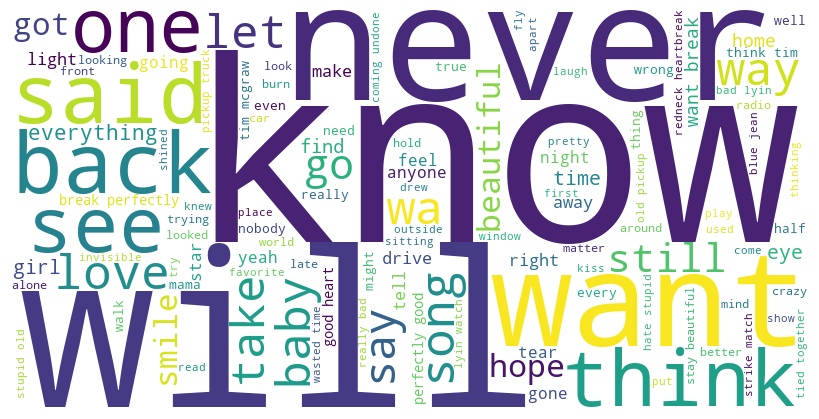

In [ ]:
debut_counts = all_words_in_album['Taylor Swift']

debut_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(debut_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(debut_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

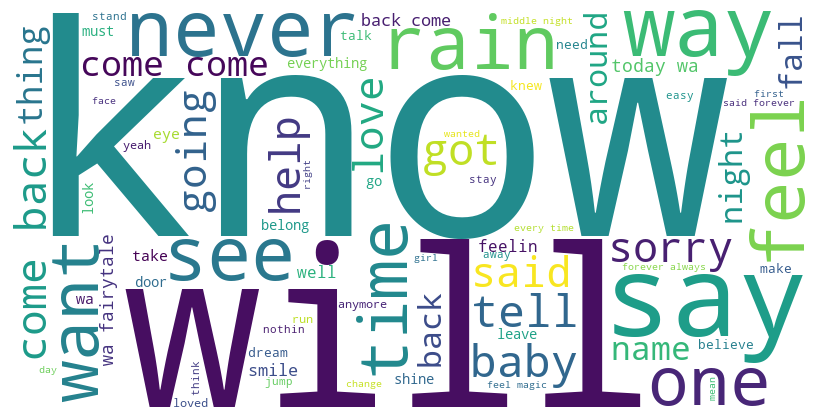

In [ ]:
fearless_counts = all_words_in_album["Fearless (Taylor's Version)"]

debut_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(fearless_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(debut_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

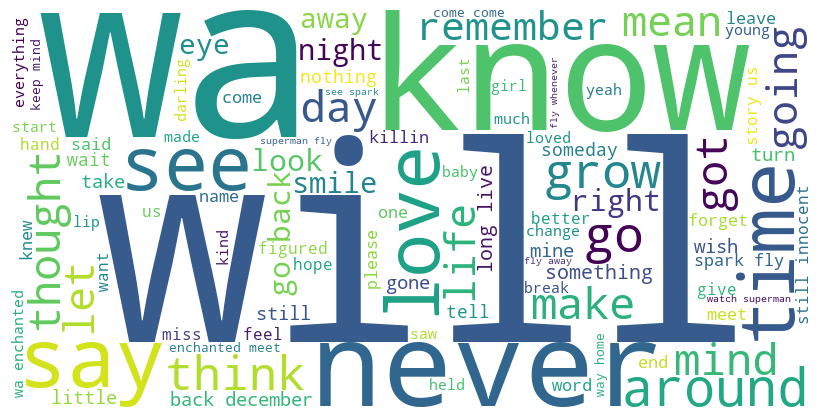

In [ ]:
speak_now_counts = all_words_in_album["Speak Now (Taylor's Version)"]

debut_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(speak_now_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(debut_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

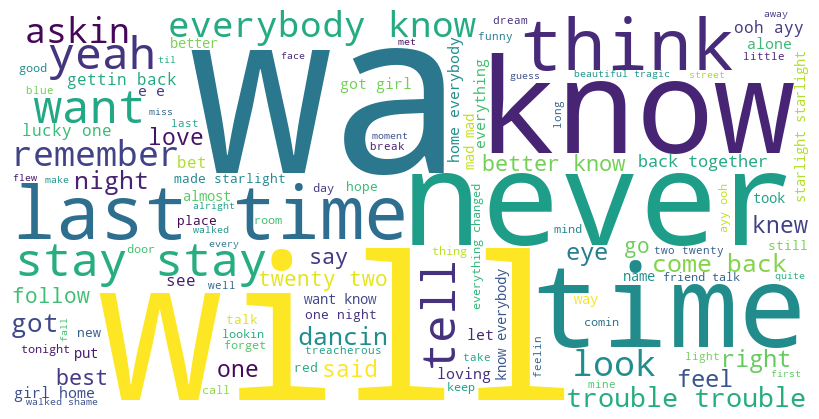

In [ ]:
red_counts = all_words_in_album["Red (Taylor's Version)"]

debut_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(red_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(debut_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

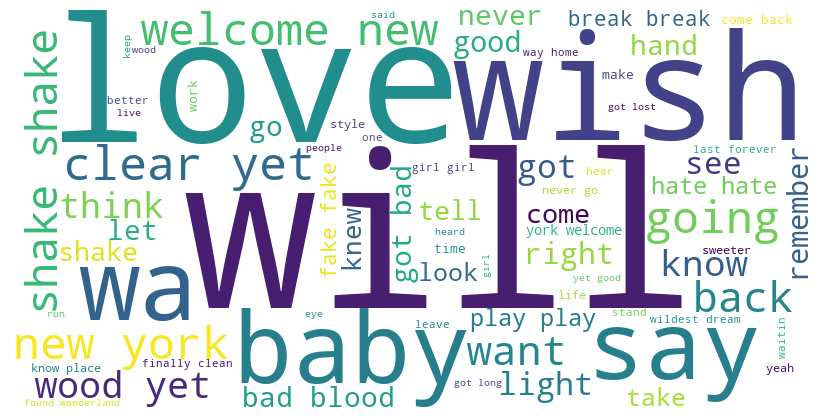

In [ ]:
eighty_nine_counts = all_words_in_album["1989 (Taylor's Version)"]

debut_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(eighty_nine_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(debut_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

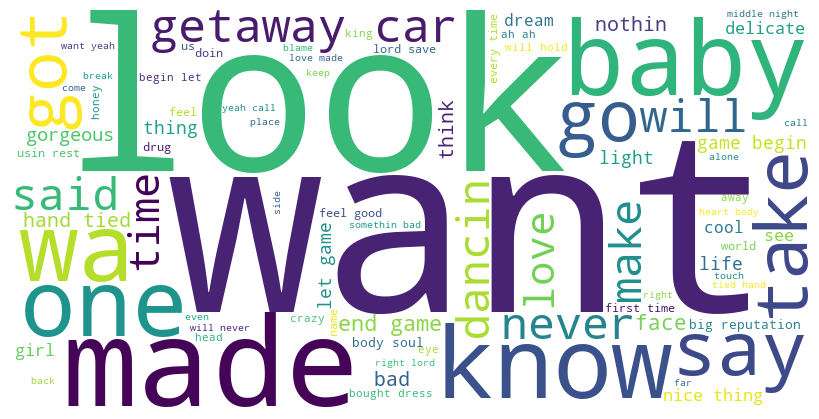

In [ ]:
rep_counts = all_words_in_album["reputation"]

rep_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(rep_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(rep_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

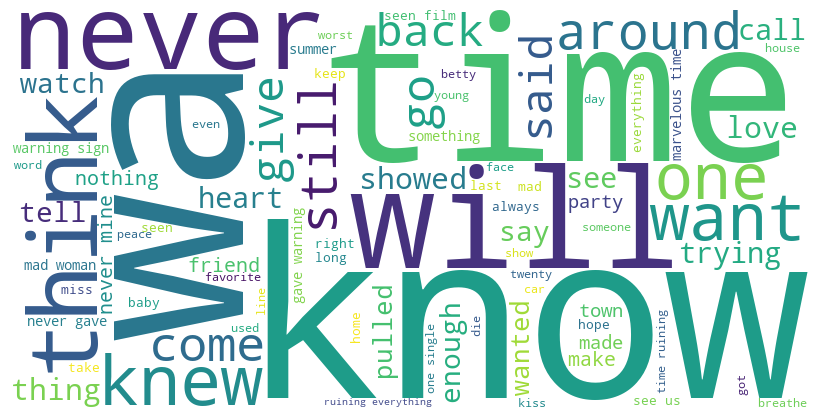

In [ ]:
folklore_counts = all_words_in_album["folklore"]

folklore_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(folklore_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(folklore_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

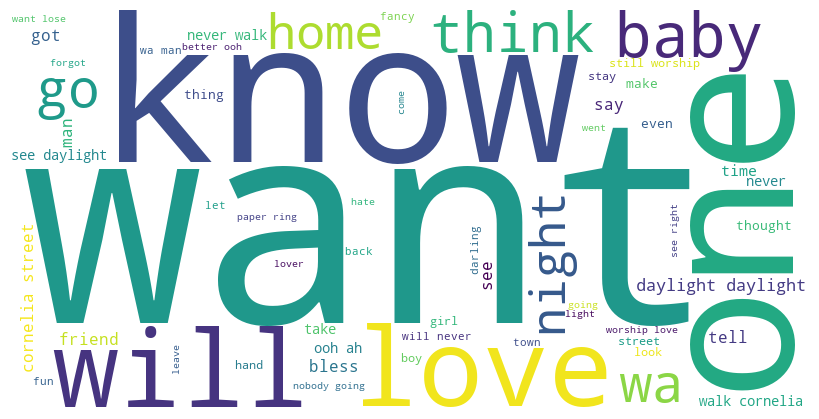

In [ ]:
lover_counts = all_words_in_album["Lover"]

lover_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(lover_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(lover_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

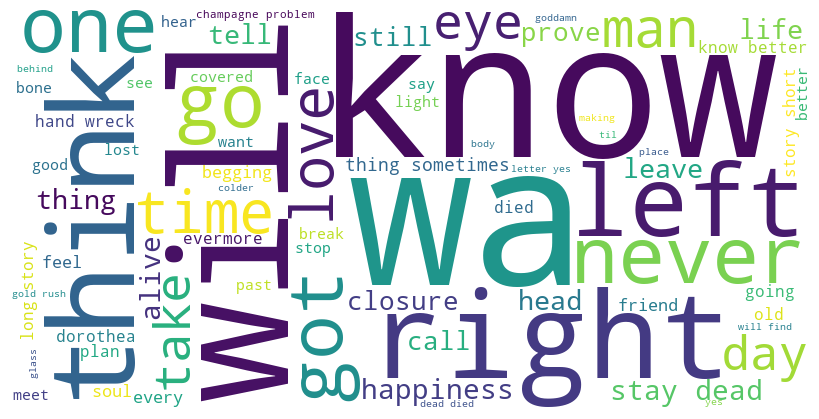

In [ ]:
evermore_counts = all_words_in_album["evermore"]

evermore_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(evermore_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(evermore_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

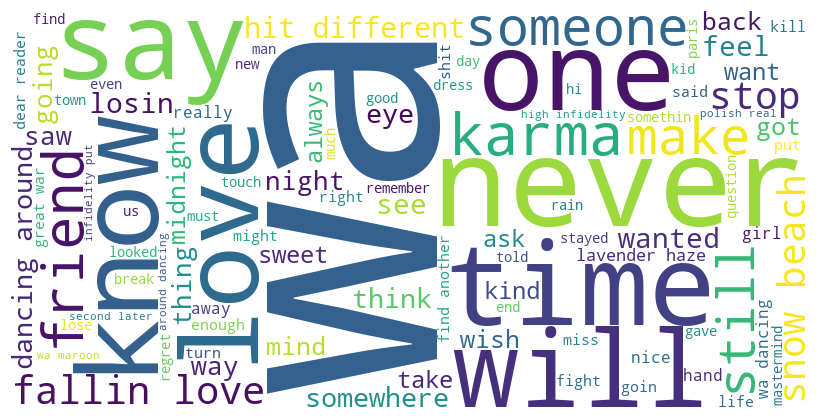

In [ ]:
midnights_counts = all_words_in_album["Midnights"]

midnights_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(midnights_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(midnights_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

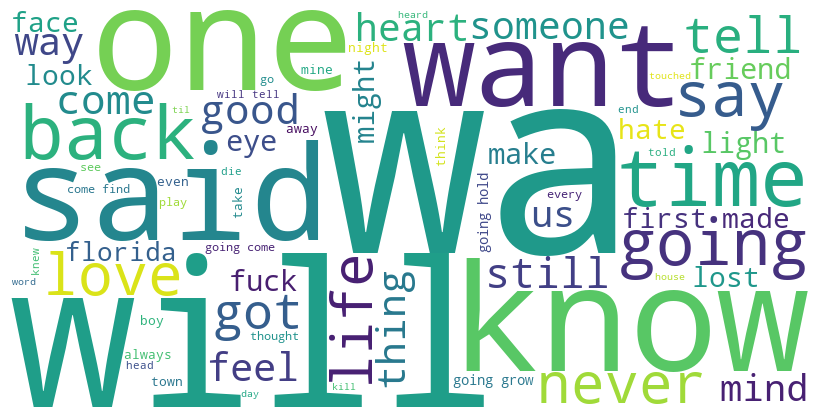

In [ ]:
poets_counts = all_words_in_album["The Tortured Poets Department"]

poets_cloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    min_font_size=10
).generate(poets_counts)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(poets_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
albums = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", 
          "Red (Taylor's Version)", "1989 (Taylor's Version)", "reputation", "Lover", 
          "folklore", "evermore", "Midnights", "The Tortured Poets Department"]

shortenings = ["Debut", "Fearless", "Speak Now", 
          "Red", "1989", "Rep", "Lover", 
          "Folklore", "Evermore", "Midnights", "TTPD"]

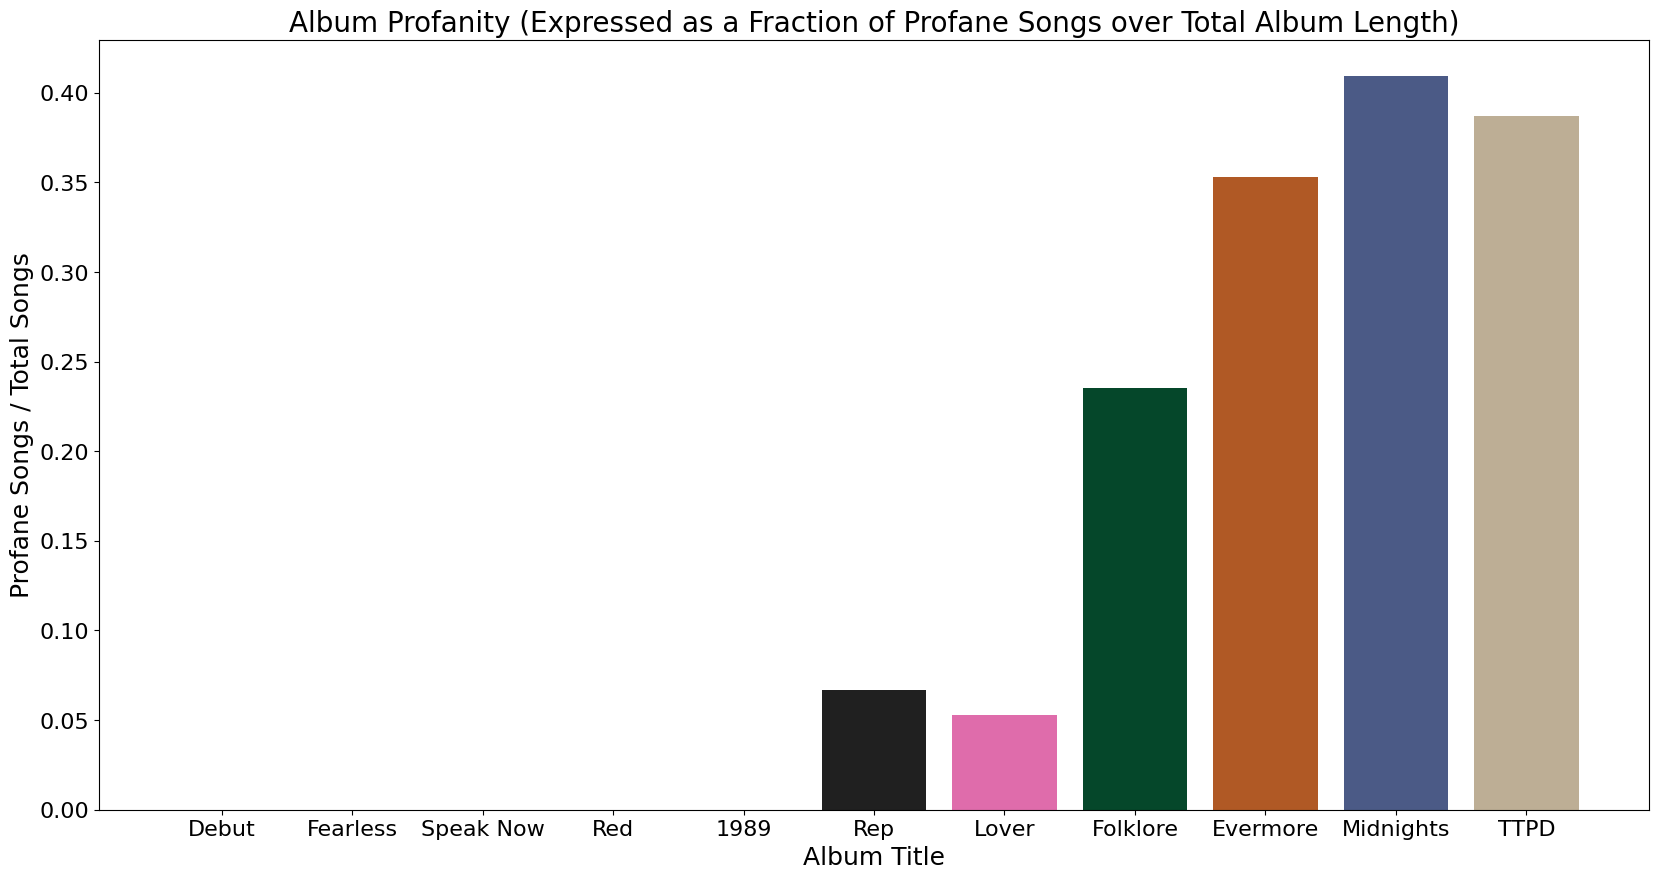

In [ ]:
plt.figure(figsize=(20, 10))

for i, album in enumerate(albums):
    plt.bar(shortenings[i], swear_dictionary[album], color=color[i])

plt.tick_params(axis="both", which='major', labelsize="16")

plt.title("Album Profanity (Expressed as a Fraction of Profane Songs over Total Album Length)", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Profane Songs / Total Songs", fontsize='18')
plt.show()

In [ ]:
swear_list = []
for album in albums:
    swear_list.append(swear_dictionary[album])

correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), swear_list)

print(correlation_coefficient)
print(p_value)

0.835878305694132
0.001350071873445367


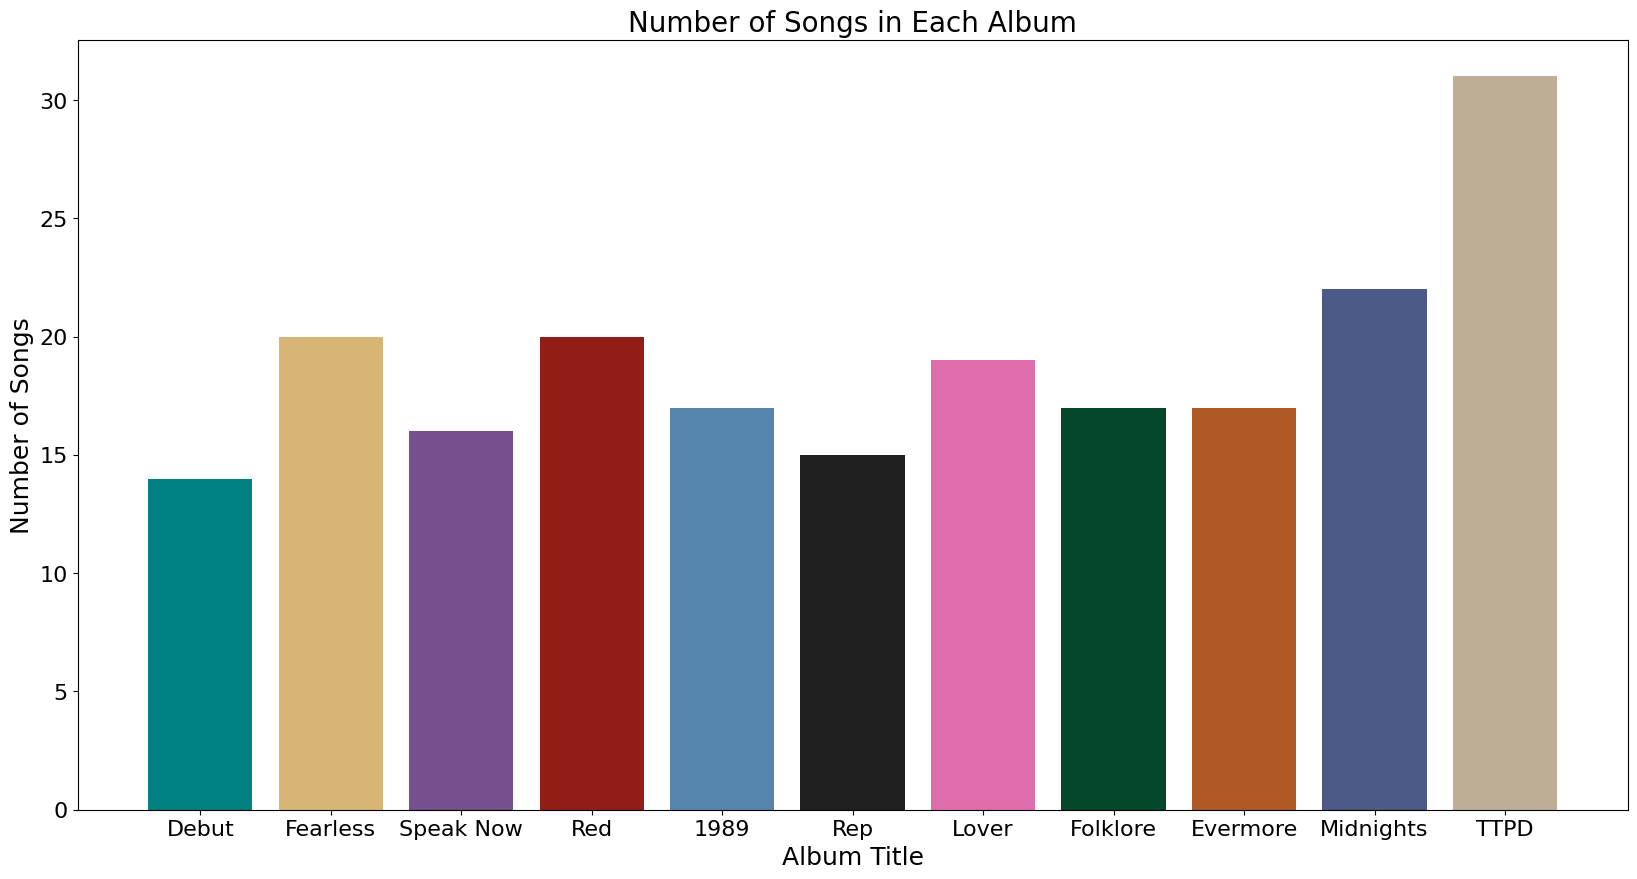

In [ ]:
plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], num_songs[album], color=color[i])

plt.title("Number of Songs in Each Album", fontsize = "20")
plt.xlabel("Album Title", fontsize = "18")
plt.ylabel("Number of Songs", fontsize = "18")

plt.show()


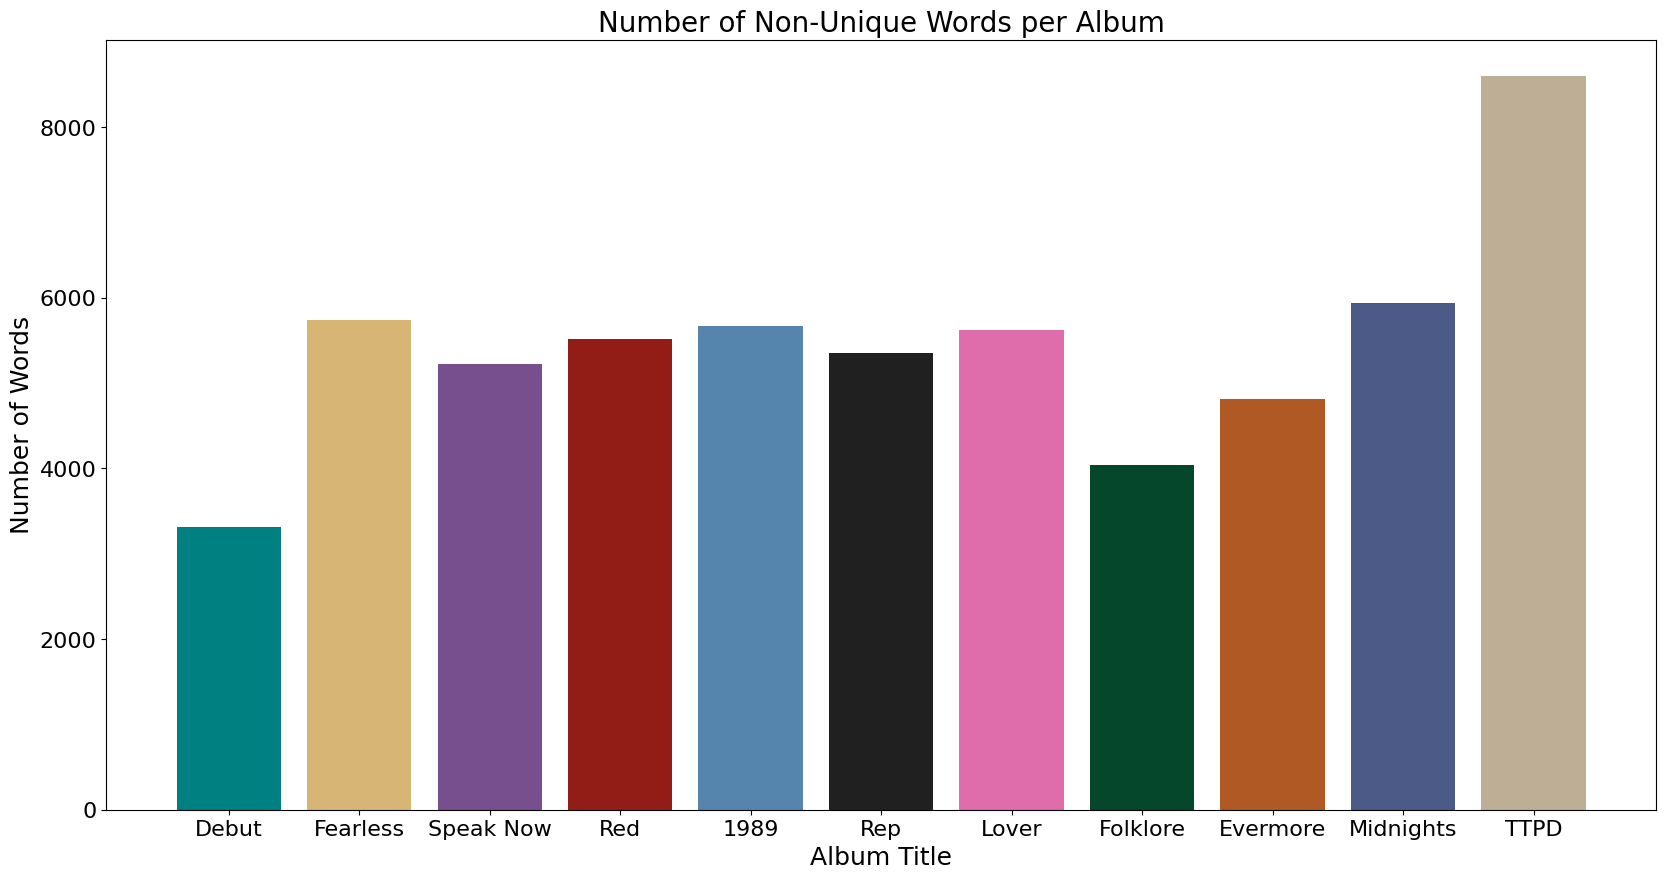

In [ ]:
plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], words_per_album[album], color=color[i])

plt.title("Number of Non-Unique Words per Album", fontsize = "20")
plt.xlabel("Album Title", fontsize = "18")
plt.ylabel("Number of Words", fontsize = "18")

plt.show()

Text(0, 0.5, 'Unique Words')

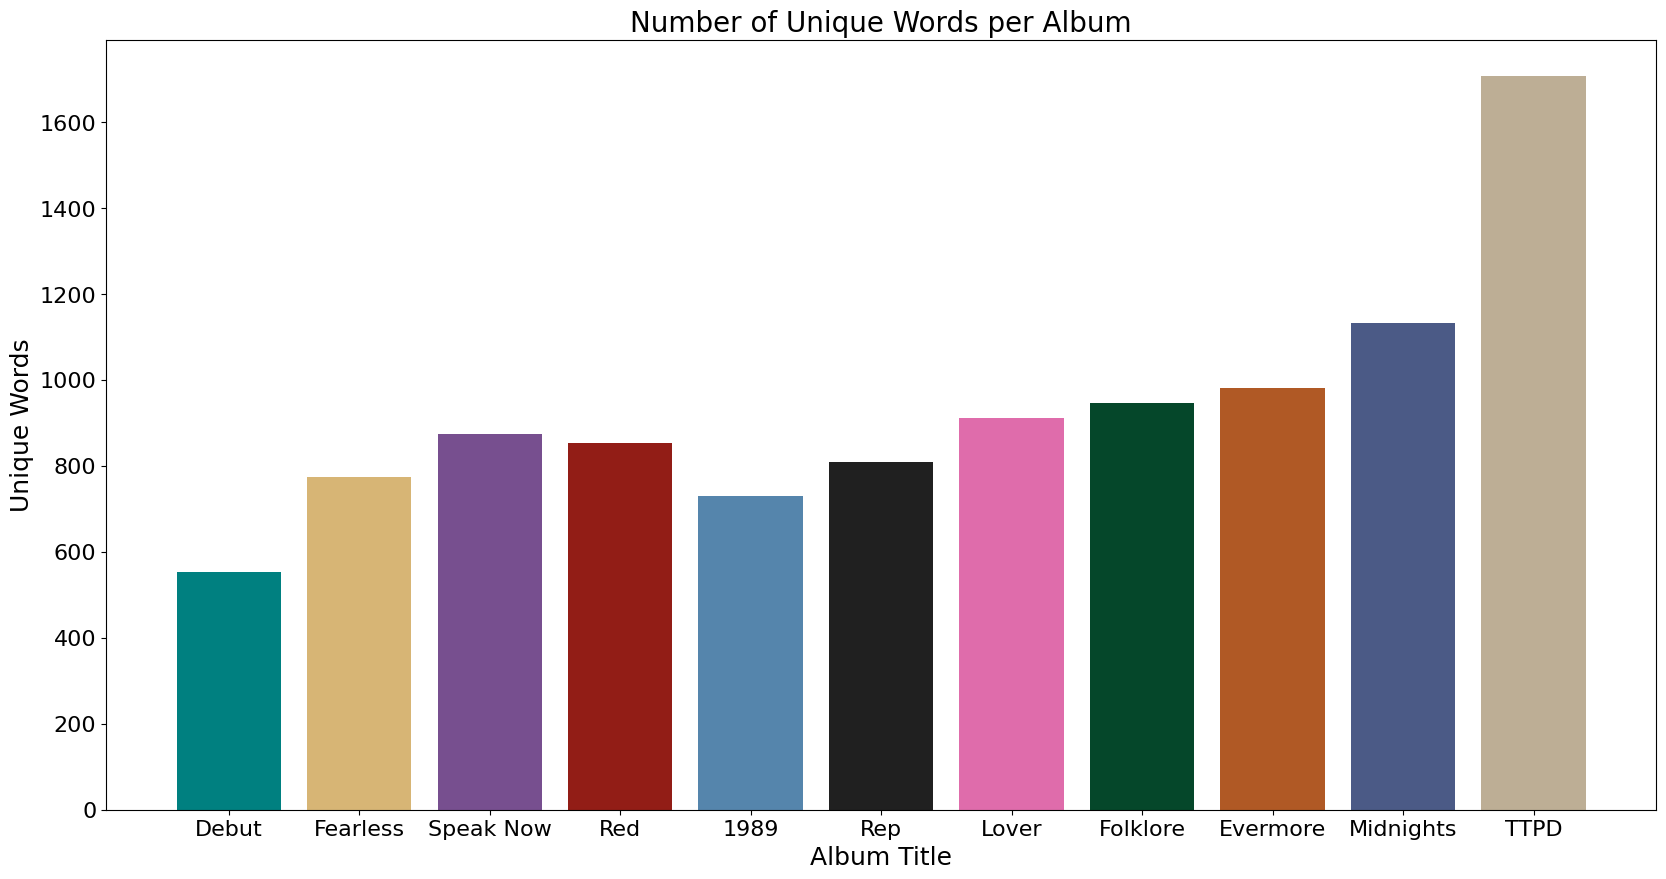

In [ ]:
plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], unique_words_per_album[album], color=color[i])

plt.title("Number of Unique Words per Album", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Unique Words", fontsize='18')

Text(0, 0.5, 'Average Number of  Words')

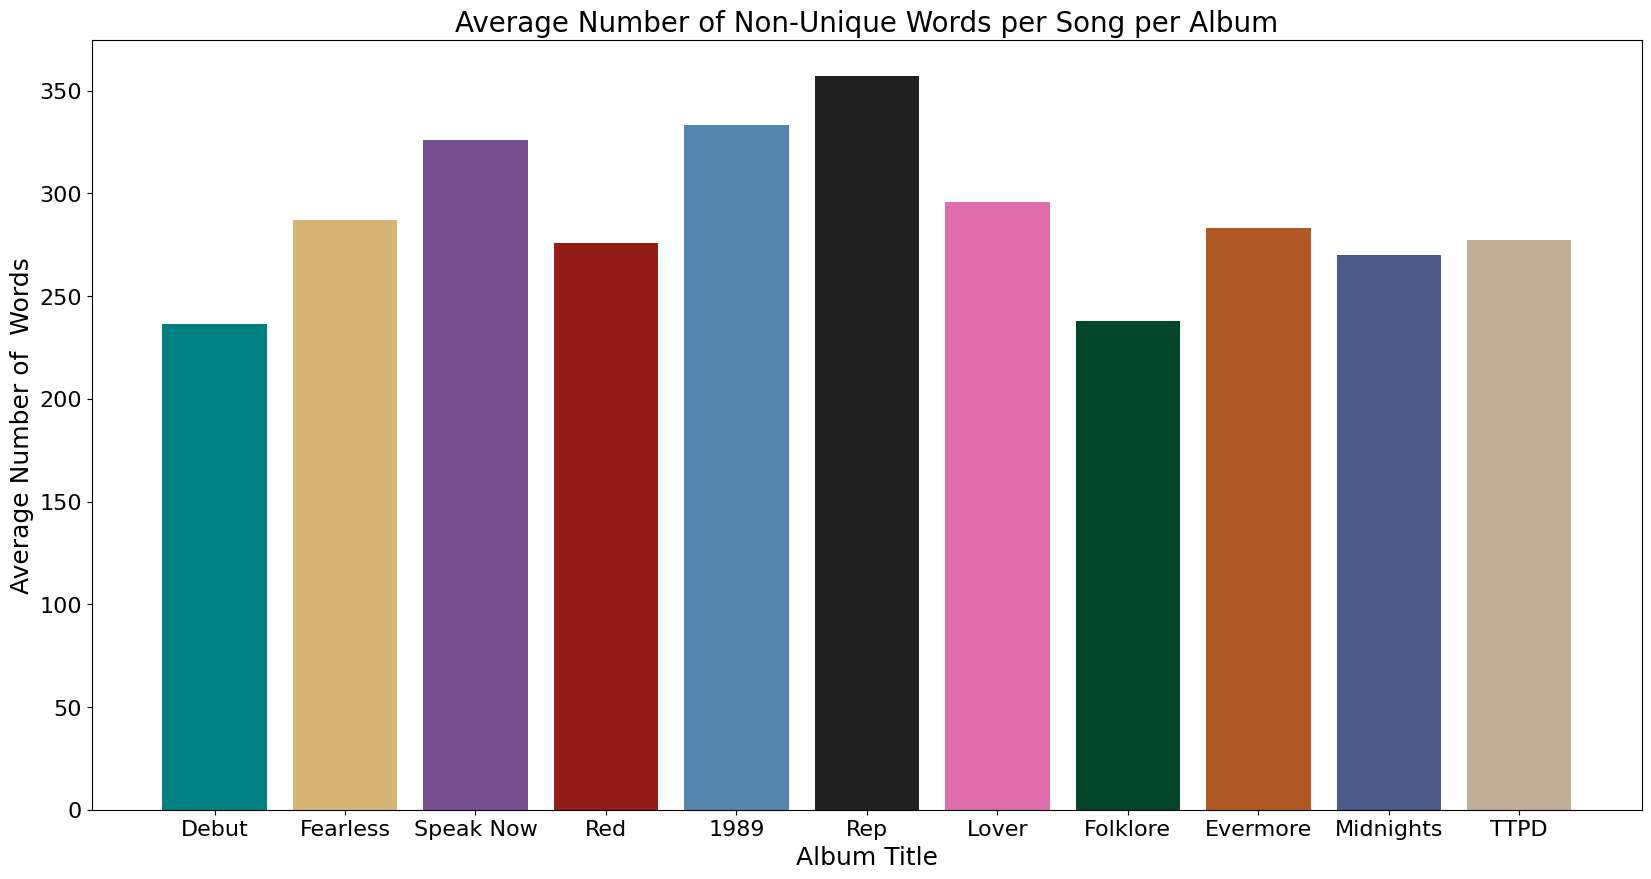

In [ ]:
plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], average_words_per_album[album], color=color[i])

plt.title("Average Number of Non-Unique Words per Song per Album", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Average Number of  Words", fontsize='18')

In [ ]:
swear_list = []
for album in albums:
    swear_list.append(average_words_per_album[album])

correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), swear_list)

print(correlation_coefficient)
print(p_value)

-0.029970019313768984
0.9302965874225948


Text(0, 0.5, 'Average Number of  Words')

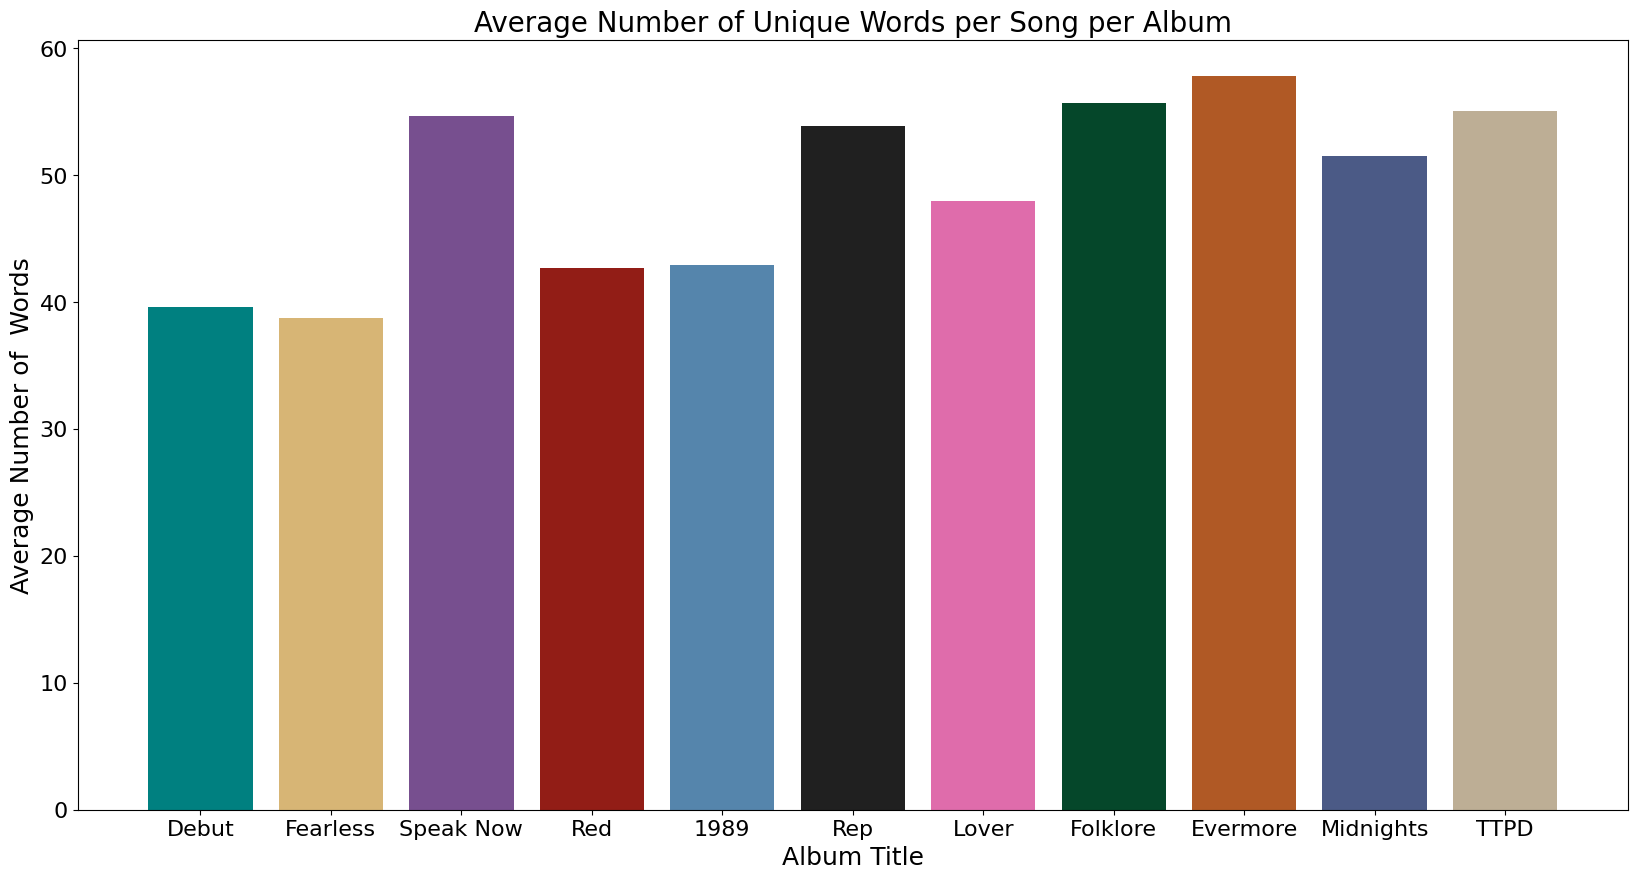

In [ ]:
plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], average_unique_words_per_album[album], color=color[i])

plt.title("Average Number of Unique Words per Song per Album", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Average Number of  Words", fontsize='18')

In [ ]:
swear_list = []
for album in albums:
    swear_list.append(average_unique_words_per_album[album])

correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), swear_list)

print(correlation_coefficient)
print(p_value)

0.7297015406384705
0.010804541887647281


In [ ]:
total_fpsp = []
total_fppp = []

for album in pronoun_dictionary:
    fpsp = 0
    fppp = 0
    for pronoun in pronoun_dictionary[album]:
        if pronoun == ("i" or "me" or "my" or "mine" or "myself"):
            fpsp += pronoun_dictionary[album][pronoun]
        elif pronoun == ("we" or "us" or "our" or "ours" or "ourselves"):
            fppp += pronoun_dictionary[album][pronoun]
    
    total_pronouns = fpsp + fppp
    total_fpsp.append(fpsp/total_pronouns)
    total_fppp.append(fppp/total_pronouns)

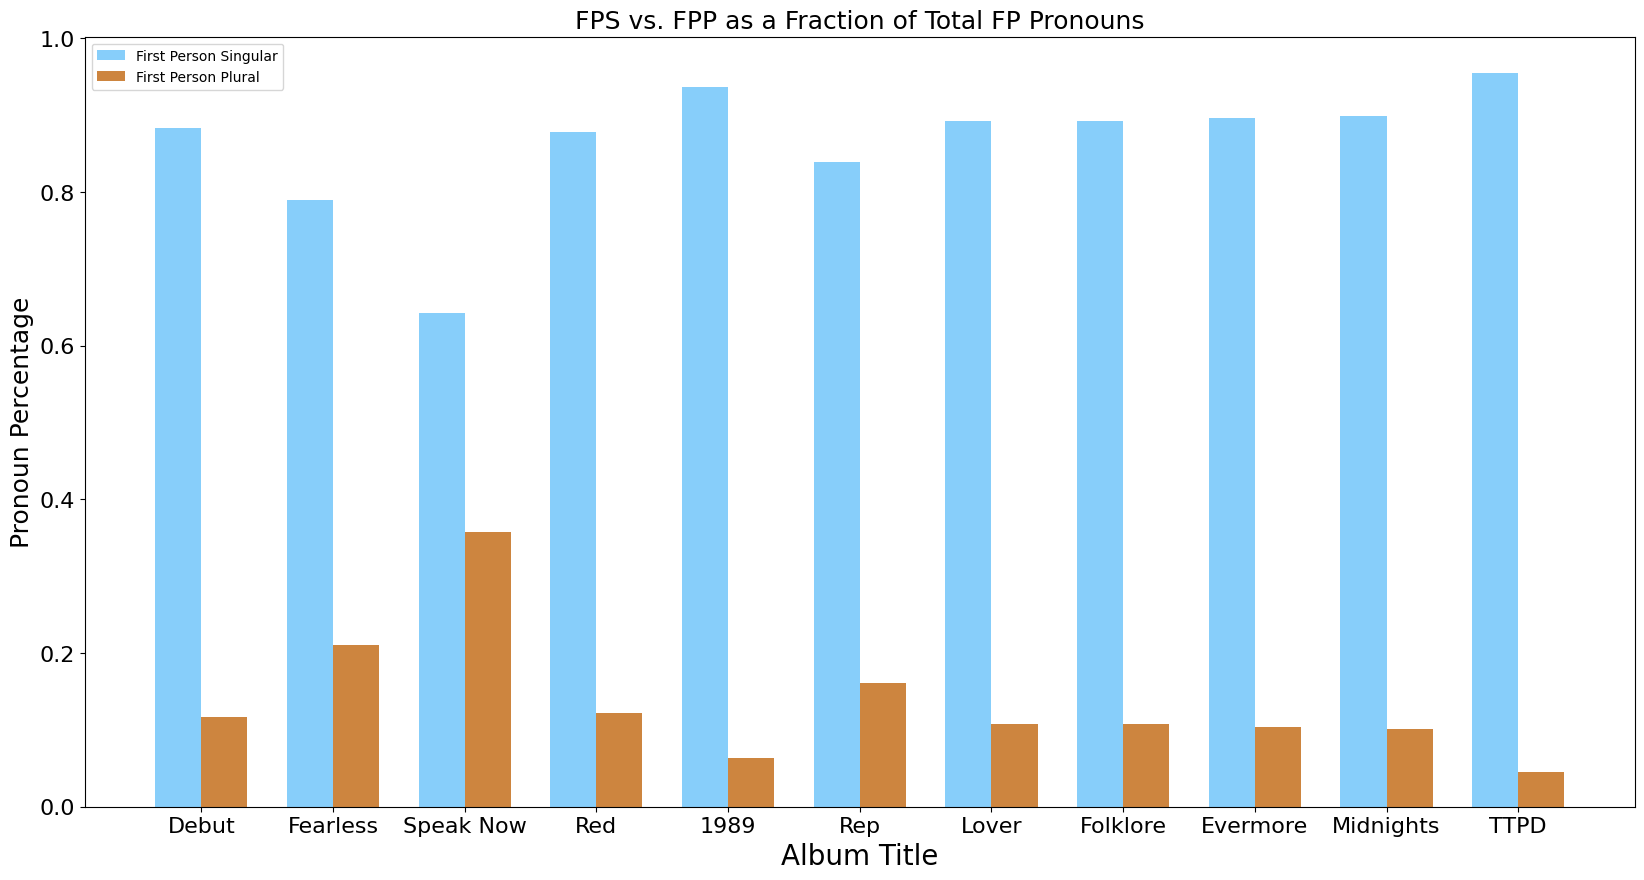

In [ ]:
# Set the width of each bar
bar_width = 0.35

# Create an array of x positions for the bars
x = np.arange(len(shortenings))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20,10))

# Plot the first set of bars
rects1 = ax.bar(x - bar_width/2, total_fpsp, bar_width, label='First Person Singular', color='lightskyblue')

# Plot the second set of bars
rects2 = ax.bar(x + bar_width/2, total_fppp, bar_width, label='First Person Plural', color='peru')

# Set the x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(shortenings)
ax.tick_params(axis="both", which='major', labelsize="16")

# Add a legend
ax.legend()

# Add labels and title
plt.xlabel('Album Title', fontsize = '20')
plt.ylabel('Pronoun Percentage', fontsize = '18')
plt.title('FPS vs. FPP as a Fraction of Total FP Pronouns', fontsize = '18')

# Show the plot
plt.show()

In [ ]:
correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), total_fpsp)

print(correlation_coefficient)
print(p_value)

0.5382977456018279
0.08758683299107203


In [ ]:
correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), total_fppp)

print(correlation_coefficient)
print(p_value)

-0.5382977456018276
0.0875868329910722


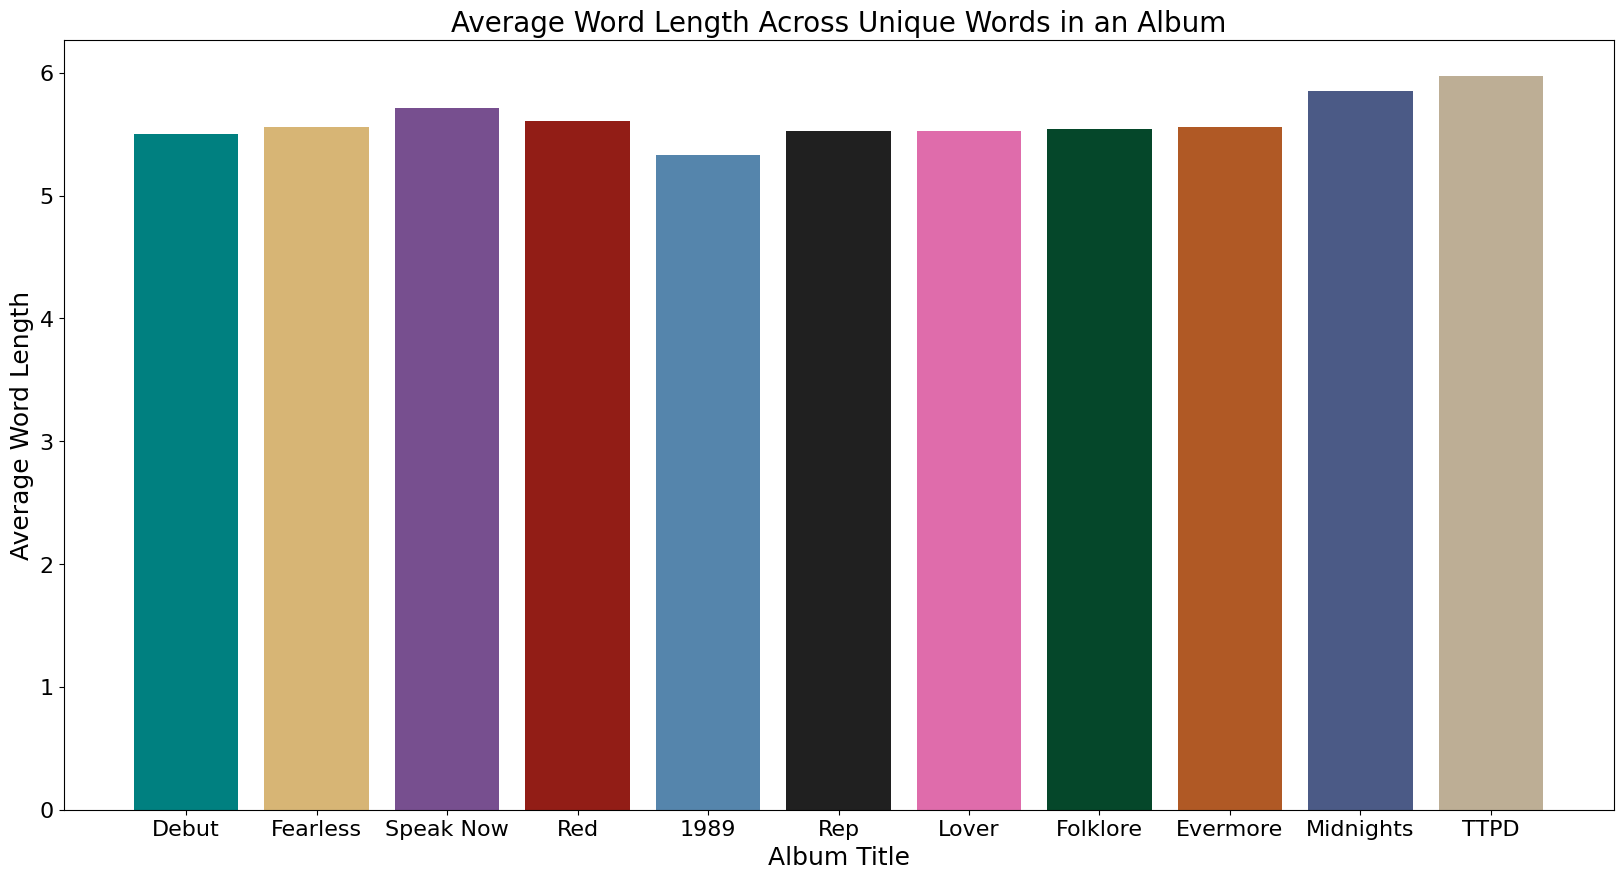

In [ ]:
plt.figure(figsize=(20, 10))

for i, album in enumerate(albums):
    plt.bar(shortenings[i], average_word_length_across_albums[album], color=color[i])

plt.tick_params(axis="both", which='major', labelsize="16")

plt.title("Average Word Length Across Unique Words in an Album", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Average Word Length", fontsize='18')
plt.show()

In [ ]:
swear_list = []
for album in albums:
    swear_list.append(average_word_length_across_albums[album])

correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), swear_list)

print(correlation_coefficient)
print(p_value)

0.4681721756044575
0.14641699047414983
